### Basic Feature Analysis and Sanity Checks

The purpose of this notebook is to analyze key application-time features
and understand how they relate to loan default risk.
This analysis focuses on:
- Checking whether important features behave logically
- Identifying strong and weak predictors
- Validating assumptions before model training




In [ ]:
##importing iib 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt




In [2]:
DATA_PATH = "../../data/raw/accepted_2007_to_2018Q4.csv"

df = pd.read_csv(DATA_PATH, low_memory=False)

In [ ]:
## extracting only "Fully Paid", "Charged Off" from "loan_status" and assigned it to a variable traget and make it binary 
df =df[df["loan_status"].isin(["Fully Paid", "Charged Off"])].copy()
df["target"] = (df["loan_status"] == "Charged Off").astype(int)

In [6]:
## select application-time features and assign them to a new variable 
features = [
    "loan_amnt",
    "term",
    "int_rate",
    "annual_inc",
    "dti",
    "emp_length",
    "home_ownership",
    "purpose"
]

df_sub = df[features + ["target"]].copy()


In [7]:
df_sub["target"].value_counts(normalize=True) * 100


target
0    80.037389
1    19.962611
Name: proportion, dtype: float64

### Target Class Distribution

The target variable is **imbalanced**:
- Around **80%** of loans are fully paid  
- Around **20%** of loans are charged off  

In [ ]:
## Loan amount vs default risk
##so we  split loans into 10 equal-sized buckets based on loan amount, and compute the default rate in each bucket.
df_sub.groupby(
    pd.qcut(df_sub["loan_amnt"], 10),
    observed=False
    )["target"].mean()



loan_amnt
(499.999, 5000.0]     0.157682
(5000.0, 6500.0]      0.158929
(6500.0, 8700.0]      0.168793
(8700.0, 10000.0]     0.182633
(10000.0, 12000.0]    0.204692
(12000.0, 15000.0]    0.210129
(15000.0, 18000.0]    0.227363
(18000.0, 21000.0]    0.226651
(21000.0, 28000.0]    0.224836
(28000.0, 40000.0]    0.244755
Name: target, dtype: float64

Text(0.5, 1.0, 'Default Rate by Loan Amount')

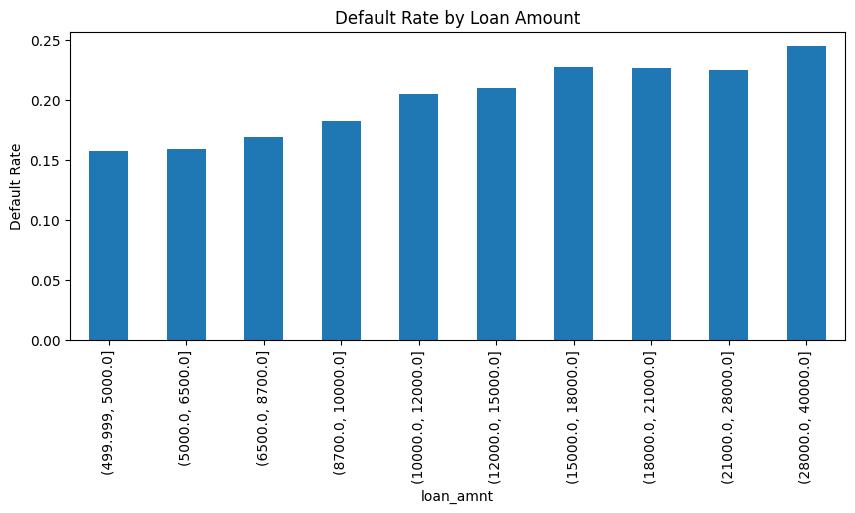

In [13]:
df_sub.groupby(pd.qcut(df_sub["loan_amnt"], 10),observed=False)["target"].mean().plot(
    kind="bar", figsize=(10,4)
)
plt.ylabel("Default Rate")
plt.title("Default Rate by Loan Amount")


Higher loan amounts tend to show higher default risk.

This aligns with business intuition, as larger loans increase
repayment burden on borrowers.


In [14]:
##Interest Rate vs Default Risk
df_sub.groupby(pd.qcut(df_sub["int_rate"], 10), observed=False)["target"].mean()


int_rate
(5.308999999999999, 7.39]    0.049128
(7.39, 8.9]                  0.084965
(8.9, 10.49]                 0.121426
(10.49, 11.53]               0.154817
(11.53, 12.74]               0.172245
(12.74, 13.98]               0.201868
(13.98, 15.22]               0.233515
(15.22, 16.99]               0.268117
(16.99, 19.52]               0.318551
(19.52, 30.99]               0.401607
Name: target, dtype: float64

Text(0.5, 1.0, 'Default Rate by Interest Rate')

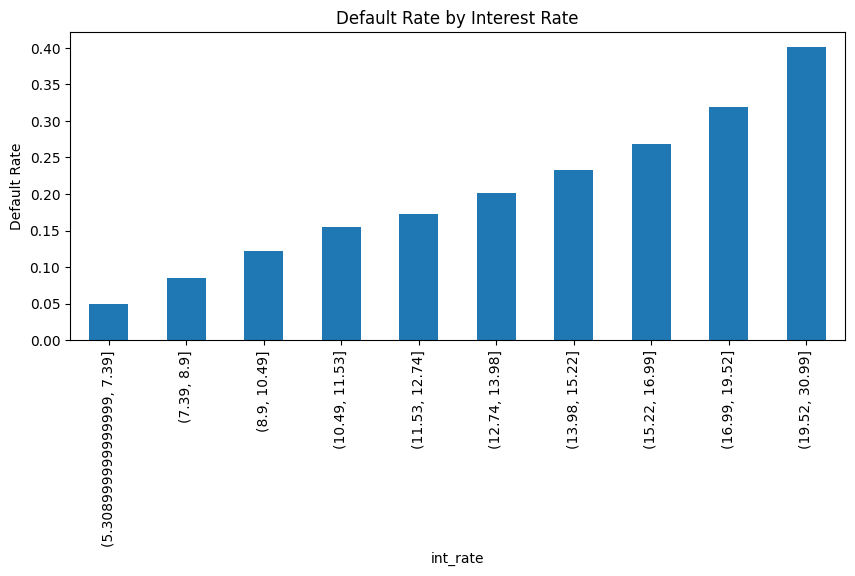

In [15]:
df_sub.groupby(pd.qcut(df_sub["int_rate"], 10), observed=False)["target"].mean().plot(
    kind="bar", figsize=(10,4)
)
plt.ylabel("Default Rate")
plt.title("Default Rate by Interest Rate")


Loans with higher interest rates show significantly higher default rates.

This makes sense because interest rate reflects the lender’s
initial risk assessment of the borrower.


In [16]:
##Debt-to-Income (DTI) Analysis
df_sub.groupby(pd.qcut(df_sub["dti"], 10),observed=False)["target"].mean()


dti
(-1.001, 7.27]    0.146525
(7.27, 10.49]     0.152568
(10.49, 13.02]    0.162289
(13.02, 15.32]    0.173080
(15.32, 17.61]    0.184789
(17.61, 19.98]    0.197072
(19.98, 22.6]     0.210828
(22.6, 25.69]     0.228335
(25.69, 29.78]    0.250907
(29.78, 999.0]    0.290132
Name: target, dtype: float64

Text(0.5, 1.0, 'Default Rate by dti')

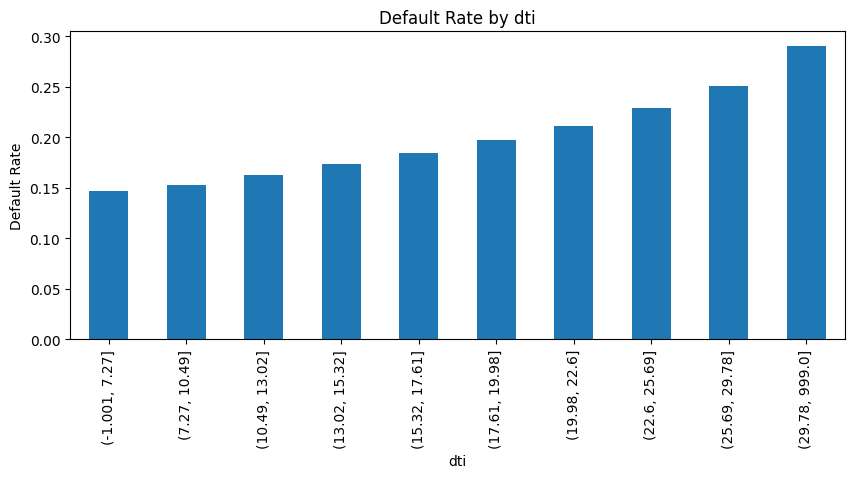

In [17]:
df_sub.groupby(pd.qcut(df_sub["dti"], 10), observed=False)["target"].mean().plot(
    kind="bar", figsize=(10,4)
)
plt.ylabel("Default Rate")
plt.title("Default Rate by dti")

As debt-to-income ratio increases, default risk generally increases.

Borrowers with higher existing debt have less financial flexibility,
making repayment more difficult.


In [19]:
df_sub["log_annual_inc"] = np.log1p(df_sub["annual_inc"])

df_sub.groupby(pd.qcut(df_sub["log_annual_inc"], 10),observed=False)["target"].mean()


log_annual_inc
(-0.001, 10.434]    0.240533
(10.434, 10.645]    0.229149
(10.645, 10.82]     0.219105
(10.82, 10.951]     0.211453
(10.951, 11.082]    0.208173
(11.082, 11.212]    0.196031
(11.212, 11.35]     0.190448
(11.35, 11.513]     0.177439
(11.513, 11.736]    0.164241
(11.736, 16.213]    0.150910
Name: target, dtype: float64

Higher income borrowers tend to have lower default rates.

Log transformation is useful because income is highly skewed
and extreme values can distort analysis.


In [20]:
df_sub.groupby("emp_length")["target"].mean().sort_values()


emp_length
10+ years    0.187827
6 years      0.193519
7 years      0.194888
5 years      0.196010
4 years      0.197378
2 years      0.198073
9 years      0.199011
8 years      0.199338
3 years      0.199690
< 1 year     0.205273
1 year       0.205641
Name: target, dtype: float64

Borrowers with longer employment history generally show
lower default risk.

Employment stability is a common factor in credit risk assessment.


In [21]:
df_sub.groupby("purpose")["target"].mean().sort_values(ascending=False)


purpose
small_business        0.297094
renewable_energy      0.236870
moving                0.233544
house                 0.218806
medical               0.217757
debt_consolidation    0.211469
other                 0.210401
vacation              0.191726
major_purchase        0.185998
home_improvement      0.177158
educational           0.171779
credit_card           0.169270
car                   0.146795
wedding               0.121622
Name: target, dtype: float64

Default risk varies by loan purpose.

This suggests that loan purpose may carry useful risk signals
and should be included as a categorical feature.
